# **Masked Language Modeling with BERT in Multi-GPU Settings**

## **Important Libraries**

### **Install**

In [1]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.8.4 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [2]:
!uv pip install -q --no-cache-dir --system accelerate

### **Import**

In [3]:
from accelerate import Accelerator, notebook_launcher # Import notebook_launcher
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    get_scheduler
)
from datasets import load_dataset

import torch
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Callable
from dataclasses import dataclass
from tqdm.auto import tqdm

import os
import random
import warnings

warnings.filterwarnings("ignore")

sns.set()

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

2025-07-31 06:46:10.054210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753944370.310336      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753944370.386911      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Configuration**

In [4]:
@dataclass
class ModelConfiguration:
    model_name: str = "bert-base-uncased"
    dataset_name: str = "wikitext-2-raw-v1"
    precision: str = "fp16"
    block_size: int = 512
    batch_size: int = 16
    num_workers: int = 2
    learning_rate: float = 2.5e-5
    num_epochs: int = 24
    # Please set the Settings > Accelerator to GPU T4 x 2
    num_gpus: int = 2 
    log_steps: int = 35
    save_dir: str = "./model"

## **Dataset**

In [5]:
class MLMDataModule(object):
    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        dataset_name: str = "wikitext-103-raw-v1",
        block_size: int = 128,
        batch_size: int = 16,
        num_workers: int = 4,
    ):
        super().__init__()
        self.model_name = model_name
        self.block_size = block_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.dataset_name = dataset_name

        # Set pad_token for DataCollatorForLanguageModeling if it's not set

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = (
                self.tokenizer.eos_token
            )  # A common fallback if pad_token is missing

    def prepare_data(self):
        # Download the dataset. This is called only once on the main process.

        load_dataset(
            "wikitext",
            self.dataset_name,
            split="train",
            cache_dir="./data",
        )
        load_dataset(
            "wikitext",
            self.dataset_name,
            split="validation",
            cache_dir="./data",
        )

    def setup(self): 
        # Load and preprocess the dataset. Called on every GPU/process.
        # We'll use a smaller subset for demonstration

        raw_datasets = load_dataset(
            "wikitext",
            self.dataset_name,
            split="train",
            cache_dir="./data",
        )
        val_datasets = load_dataset(
            "wikitext",
            self.dataset_name,
            split="validation",
            cache_dir="./data",
        )

        # Wikitext-103-raw-v1 contains empty strings and sometimes lines with just
        # " = Article Title = ".
        # We'll filter these out.

        def filter_empty_or_title_lines(example):
            # Filter out empty strings and Wikipedia-style section headers
            text = example["text"].strip()
            return len(text) > 0 and not (
                text.startswith("=") and text.endswith("=")
            )

        raw_datasets = raw_datasets.filter(
            filter_empty_or_title_lines, num_proc=self.num_workers)
        val_datasets = val_datasets.filter(
            filter_empty_or_title_lines, num_proc=self.num_workers
        )

        # Tokenize the dataset
        def tokenize_function(examples):
            # Do not truncate here, we'll group later
            return self.tokenizer(examples["text"], truncation=False)

        tokenized_datasets = raw_datasets.map(
            tokenize_function,
            batched=True,
            num_proc=self.num_workers,
            # Remove the original text column after tokenization
            remove_columns=["text"],
            desc="Running tokenizer on dataset",
        )
        tokenized_val_datasets = val_datasets.map(
            tokenize_function,
            batched=True,
            num_proc=self.num_workers,
            remove_columns=["text"],
            desc="Running tokenizer on validation dataset",
        )

        # Group texts into blocks of block_size
        def group_texts(examples):
            # Concatenate all texts.
            concatenated_examples = {
                k: sum(examples[k], []) for k in examples.keys()
            }
            total_length = len(concatenated_examples[list(examples.keys())[0]])
            # We drop the small remainder.
            total_length = (total_length // self.block_size) * self.block_size
            # Split by chunks of max_len.
            result = {
                k: [
                    t[i : i + self.block_size]
                    for i in range(0, total_length, self.block_size)
                ]
                for k, t in concatenated_examples.items()
            }
            result["labels"] = result["input_ids"].copy()
            return result

        self.train_dataset = tokenized_datasets.map(
            group_texts,
            batched=True,
            num_proc=self.num_workers,
            desc=f"Grouping texts in chunks of {self.block_size}",
        )
        self.val_dataset = tokenized_val_datasets.map(
            group_texts,
            batched=True,
            num_proc=self.num_workers,
            desc=f"Grouping texts in chunks of {self.block_size}",
        )

        # Print some info for verification
        print(
            "\nNumber of training examples after processing: "
            f"{len(self.train_dataset)}"
        )
        print(
            "\nNumber of validation examples after processing: "
            f"{len(self.val_dataset)}"
        )

    def train_dataloader(self):
        # DataCollatorForLanguageModeling handles dynamic masking for MLM
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer, mlm=True, mlm_probability=0.15
        )
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            collate_fn=data_collator,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer, mlm=True, mlm_probability=0.15
        )
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            collate_fn=data_collator,
            num_workers=self.num_workers,
        )

## **Model**

In [6]:
class MLMModel(torch.nn.Module):
    def __init__(self, model_name: str = "bert-base-uncased"):
        super().__init__()
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        return outputs

## **Training**

In [7]:
def train_function(config): # Takes 'config' from notebook_launcher
    # Unpack config
    model_name = config.model_name
    dataset_name = config.dataset_name
    block_size = config.block_size
    batch_size = config.batch_size
    num_workers = config.num_workers
    learning_rate = config.learning_rate
    num_epochs = config.num_epochs
    log_steps = config.log_steps
    save_dir = config.save_dir
    precision = config.precision

    # Initialize Accelerator
    accelerator = Accelerator(
        mixed_precision=precision,
    )
    
    # Create DataModule and set it up
    data_module = MLMDataModule(
        model_name=model_name,
        dataset_name=dataset_name,
        block_size=block_size,
        batch_size=batch_size,
        num_workers=num_workers,
    )
    data_module.prepare_data()
    data_module.setup()

    train_dataloader = data_module.train_dataloader()
    val_dataloader = data_module.val_dataloader()

    total_training_steps = len(train_dataloader) * num_epochs
    num_warmup_steps = int(0.1 * total_training_steps)

    model = MLMModel(model_name=model_name)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=total_training_steps,
    )

    (
        model,
        optimizer, 
        train_dataloader, 
        val_dataloader, 
        lr_scheduler
    ) = accelerator.prepare(
        model,
        optimizer, 
        train_dataloader, 
        val_dataloader, 
        lr_scheduler
    )

    accelerator.print(
        f"Starting training for {num_epochs} epochs on "
        f"{accelerator.num_processes} processes."
    )
    accelerator.print(
        f"Total training steps: {total_training_steps}"
    )
    accelerator.print(
        "Number of effective batches per epoch"
        f" (per device): {len(train_dataloader)}"
    )
    accelerator.print(
        f"Effective total batch size: {batch_size * accelerator.num_processes}"
    )

    best_val_loss = float('inf')

    # Lists to store loss for plotting
    train_losses_for_plot = list()
    train_steps_for_plot = list()

    for epoch in range(num_epochs):
        # --- Training Phase ---
        
        model.train()
        total_train_loss = 0
        
        if accelerator.is_main_process:
            progress_bar = tqdm(range(len(train_dataloader)), desc=f"Epoch {epoch+1}")
        else:
            progress_bar = None

        for step, batch in enumerate(train_dataloader):
            global_step = (epoch * len(train_dataloader)) + step
            
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"],
            )
            loss = outputs.loss
            
            accelerator.backward(loss)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()

            if progress_bar:
                progress_bar.update(1)
                progress_bar.set_postfix(loss=loss.item())

            if (step + 1) % log_steps == 0:
                accelerator.log(
                    {"train_loss_step": loss.item()}, 
                    step=global_step,
                )
                if accelerator.is_main_process:
                    train_losses_for_plot.append(loss.item())
                    train_steps_for_plot.append(global_step)

        avg_train_loss = total_train_loss / len(train_dataloader)
        accelerator.log(
            {"train_loss_epoch": avg_train_loss}, 
            step=(epoch * len(train_dataloader)) + step
        )
        accelerator.print(
            f"Epoch {epoch+1} finished. Avg Train Loss: {avg_train_loss:.4f}"
        )
        if progress_bar:
            progress_bar.close()

        # --- Evaluation Phase ---

        model.eval()
        total_val_loss = 0
        for batch in val_dataloader:
            with torch.no_grad():
                outputs = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["labels"],
                )
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        accelerator.log(
            {"val_loss_epoch": avg_val_loss}, 
            step=(epoch * len(train_dataloader)) + step
        )
        accelerator.print(
            f"Epoch {epoch+1} finished. Avg Val Loss: {avg_val_loss:.4f}"
        )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            unwrapped_model = accelerator.unwrap_model(model)
            accelerator.save_state(output_dir=save_dir)
            accelerator.print(
                f"Saved best model state with validation loss: {best_val_loss:.4f}"
            )

    accelerator.print("\nTraining complete!")
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.model.save_pretrained(f"{save_dir}/mlm_bert_multigpu")
    accelerator.print(f"Final Hugging Face model saved to {save_dir}/mlm_bert_multigpu")

    # --- Plotting the training loss and saving tokenizer (Only on the main process) ---
    if accelerator.is_main_process:
        tokenizer = data_module.tokenizer
        tokenizer.save_pretrained(f"{save_dir}/mlm_bert_multigpu")
        accelerator.print(f"Tokenizer saved to {save_dir}/mlm_bert_multigpu")
        plt.figure(figsize=(10, 6))
        plt.plot(train_steps_for_plot, train_losses_for_plot, label='Training Loss')
        plt.xlabel('Global Step')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Steps')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Optionally save the plot
        plt.savefig(f"{save_dir}/training_loss_plot.png")
        accelerator.print(
            f"Training loss plot saved to {save_dir}/training_loss_plot.png"
        )

Launching training on 2 GPUs.


Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors



Number of training examples after processing: 4468

Number of validation examples after processing: 463

Number of training examples after processing: 4468

Number of validation examples after processing: 463


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

Starting training for 24 epochs on 2 processes.
Total training steps: 6720
Number of effective batches per epoch (per device): 140
Effective total batch size: 32


Epoch 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 finished. Avg Train Loss: 2.1523
Epoch 1 finished. Avg Val Loss: 1.7674
Saved best model state with validation loss: 1.7674


Epoch 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 finished. Avg Train Loss: 1.8710
Epoch 2 finished. Avg Val Loss: 1.7033
Saved best model state with validation loss: 1.7033


Epoch 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 finished. Avg Train Loss: 1.7950
Epoch 3 finished. Avg Val Loss: 1.6604
Saved best model state with validation loss: 1.6604


Epoch 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 finished. Avg Train Loss: 1.7562
Epoch 4 finished. Avg Val Loss: 1.6239
Saved best model state with validation loss: 1.6239


Epoch 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 finished. Avg Train Loss: 1.7125
Epoch 5 finished. Avg Val Loss: 1.6204
Saved best model state with validation loss: 1.6204


Epoch 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 finished. Avg Train Loss: 1.6920
Epoch 6 finished. Avg Val Loss: 1.6014
Saved best model state with validation loss: 1.6014


Epoch 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 finished. Avg Train Loss: 1.6560
Epoch 7 finished. Avg Val Loss: 1.5717
Saved best model state with validation loss: 1.5717


Epoch 8:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8 finished. Avg Train Loss: 1.6489
Epoch 8 finished. Avg Val Loss: 1.5850


Epoch 9:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9 finished. Avg Train Loss: 1.6354
Epoch 9 finished. Avg Val Loss: 1.5674
Saved best model state with validation loss: 1.5674


Epoch 10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10 finished. Avg Train Loss: 1.6286
Epoch 10 finished. Avg Val Loss: 1.5737


Epoch 11:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11 finished. Avg Train Loss: 1.6023
Epoch 11 finished. Avg Val Loss: 1.5309
Saved best model state with validation loss: 1.5309


Epoch 12:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 12 finished. Avg Train Loss: 1.5964
Epoch 12 finished. Avg Val Loss: 1.5950


Epoch 13:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 13 finished. Avg Train Loss: 1.5683
Epoch 13 finished. Avg Val Loss: 1.5660


Epoch 14:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 14 finished. Avg Train Loss: 1.5703
Epoch 14 finished. Avg Val Loss: 1.5364


Epoch 15:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 15 finished. Avg Train Loss: 1.5777
Epoch 15 finished. Avg Val Loss: 1.5355


Epoch 16:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 16 finished. Avg Train Loss: 1.5498
Epoch 16 finished. Avg Val Loss: 1.5916


Epoch 17:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 17 finished. Avg Train Loss: 1.5567
Epoch 17 finished. Avg Val Loss: 1.5622


Epoch 18:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 18 finished. Avg Train Loss: 1.5492
Epoch 18 finished. Avg Val Loss: 1.5290
Saved best model state with validation loss: 1.5290


Epoch 19:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 19 finished. Avg Train Loss: 1.5421
Epoch 19 finished. Avg Val Loss: 1.5170
Saved best model state with validation loss: 1.5170


Epoch 20:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 20 finished. Avg Train Loss: 1.5281
Epoch 20 finished. Avg Val Loss: 1.5335


Epoch 21:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 21 finished. Avg Train Loss: 1.5254
Epoch 21 finished. Avg Val Loss: 1.4871
Saved best model state with validation loss: 1.4871


Epoch 22:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 22 finished. Avg Train Loss: 1.5250
Epoch 22 finished. Avg Val Loss: 1.5477


Epoch 23:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 23 finished. Avg Train Loss: 1.5131
Epoch 23 finished. Avg Val Loss: 1.5375


Epoch 24:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 24 finished. Avg Train Loss: 1.5287
Epoch 24 finished. Avg Val Loss: 1.5449

Training complete!
Final Hugging Face model saved to ./model/mlm_bert_multigpu
Tokenizer saved to ./model/mlm_bert_multigpu


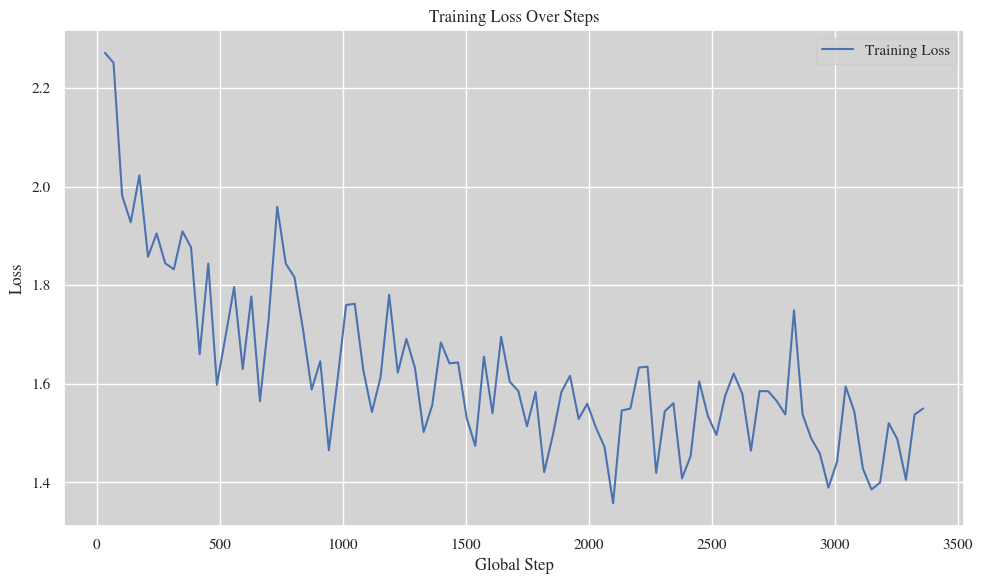

Training loss plot saved to ./model/training_loss_plot.png


In [8]:
config = ModelConfiguration()

# Note: Always use latest environment in Session options
# Launch the training function with notebook_launcher
# The first argument is the function to run
# The second argument is a tuple/list of arguments to pass to the function
# The num_processes argument is crucial for multi-GPU
notebook_launcher(
    train_function,
    (config,), # Pass your args dict inside a tuple/list
    num_processes=config.num_gpus,
    mixed_precision=config.precision, # mixed precision
)

## **Inference**

In [9]:
from transformers import pipeline

In [10]:
def create_mlm_pipeline(
    model_path: str = None, 
    model_name: str = "bert-base-uncased",
):
    """
    Create a pipeline for masked language modeling.
    
    Args:
        model_path (str, optional): Path to a trained model.
                                    Defaults to None.
        model_name (str, optional): The name of the pre-trained model to use
                                    if model_path is None. Defaults to
                                    "bert-base-uncased".
    Return:
        The pipeline for masked language modeling.
    """
    print("Loading model and tokenizer...")

    try:
        model = AutoModelForMaskedLM.from_pretrained(model_path)
    except Exception as e:
        print(f"Cannot load model: {e}")
        model = AutoModelForMaskedLM.from_pretrained(model_name)

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
    except Exception as e:
        print(f"Cannot load tokenizer: {e}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Move model to GPU if available

    device = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU
    print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

    # Create the fill-mask pipeline
    # The pipeline handles tokenization, model inference, and decoding
    # the predictions.
    # Read more: https://huggingface.co/tasks/fill-mask

    print(
        "Creating fill-mask pipeline...\n"
        "Read more: https://huggingface.co/tasks/fill-mask"
    )

    fill_mask_pipeline = pipeline(
        "fill-mask",
        model=model,
        tokenizer=tokenizer,
        device=device,  # Pass the device for GPU acceleration
    )
    
    return fill_mask_pipeline

In [11]:
@torch.no_grad()
def fill_mask_inference(sentence: str, fill_mask_pipeline: Callable):
    """
    Performs masked language modeling inference to fill in masked tokens.

    Args:
        sentence (str) : A masked sentence to be filled in.
        fill_mask_pipeline (Callable): A pipeline function for masked language modeling.
    """

    print("\n--- Masked Language Modeling Inference ---")

    print(f"Input sentence: {sentence}")

    # Get predictions

    results = fill_mask_pipeline(sentence)

    # Print top predictions

    print("Top 5 predictions:")

    if isinstance(results[0], list):
        while isinstance(results[0], list):
            res = results[0]
            if random.random() > 0.5:
                prob = 0.
                prob_dist = list()
                for r in res:
                    prob += r['score']
                    prob_dist.append(r['score'])
                prob_dist = np.array(prob_dist)
                prob_dist = prob_dist / np.sum(prob_dist)
                index = np.random.choice(len(res), p=prob_dist)
            else:
                index = random.randint(0, len(res) - 1)
            seq = res[index]['sequence']
            results = fill_mask_pipeline(seq)

    for res in results[:5]:  # Show top 5 predictions
        # The result includes 'score', 'token', 'token_str', 'sequence'
        print(
            f"  Token: '{res['token_str']}' | Score: {res['score']:.4f}"
            f" | Sequence: '{res['sequence']}'"
        )

In [12]:
model_ckpt_path = (
    "./model/mlm_bert_multigpu"
)

config = ModelConfiguration()

In [13]:
# Example sentences to fill
sentences = [
    "The capital of France is [MASK].",
    "I enjoy [MASK] and coding.",
    "The quick brown fox jumps over the lazy [MASK].",
    "Artificial intelligence is a rapidly [MASK] field.",
    "Learning a new language can be [MASK] but rewarding.",
    "[MASK] lives in Metropolis.",
    "Teach him how to [MASK] and you feed him for a lifetime.",
    "Muslims pray [MASK] times a day.",
    "You are my [MASK] that shines my [MASK].",
    "I am too [MASK] for this [MASK], I [MASK]!",
    "This is the [MASK] [MASK] of my [MASK]!",
    "Hello, [MASK] [MASK] [MASK] Einstein and I am [MASK]!",
    "You are [MASK] [MASK] [MASK] [MASK].",
    "He [MASK] [MASK] [MASK] [MASK] [MASK].",
    "[MASK] [MASK] [MASK] [MASK] [MASK] [MASK].",
    "[MASK] [MASK] [MASK] [MASK] [MASK] [MASK]!",
    "[MASK] [MASK] [MASK] [MASK] [MASK] [MASK]?",
    "Deep learning is [MASK] [MASK] [MASK] [MASK] [MASK] [MASK].",
    "Are neural networks [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]?",
    "Please [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]!",
]

for i, sentence in enumerate(sentences):
    print(f"\nExample {i+1}:")
    mlm_pipeline = create_mlm_pipeline(model_ckpt_path, config.model_name)
    fill_mask_inference(sentence, mlm_pipeline)


Example 1:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: The capital of France is [MASK].


Device set to use cuda:0


Top 5 predictions:
  Token: 'paris' | Score: 0.3456 | Sequence: 'the capital of france is paris.'
  Token: 'lille' | Score: 0.0928 | Sequence: 'the capital of france is lille.'
  Token: 'marseille' | Score: 0.0740 | Sequence: 'the capital of france is marseille.'
  Token: 'var' | Score: 0.0527 | Sequence: 'the capital of france is var.'
  Token: 'lyon' | Score: 0.0512 | Sequence: 'the capital of france is lyon.'

Example 2:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: I enjoy [MASK] and coding.
Top 5 predictions:
  Token: 'writing' | Score: 0.1428 | Sequence: 'i enjoy writing and coding.'
  Token: 'reading' | Score: 0.1050 | Sequence: 'i enjoy reading and coding.'
  Token: 'math' | Score: 0.0592 | Sequence: 'i enjoy math and coding.'
  Token: 'chess' | Score: 0.0360 | Sequence: 'i enjoy chess and coding.'
  Token: 'games' | Score: 0.0277 | Seq

Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: The quick brown fox jumps over the lazy [MASK].
Top 5 predictions:
  Token: 'fox' | Score: 0.4378 | Sequence: 'the quick brown fox jumps over the lazy fox.'
  Token: 'hare' | Score: 0.0301 | Sequence: 'the quick brown fox jumps over the lazy hare.'
  Token: 'river' | Score: 0.0287 | Sequence: 'the quick brown fox jumps over the lazy river.'
  Token: 'brook' | Score: 0.0196 | Sequence: 'the quick brown fox jumps over the lazy brook.'
  Token: 'bird' | Score: 0.0177 | Sequence: 'the quick brown fox jumps over the lazy bird.'

Example 4:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: Artificial intelligence is a rapidly [MASK] field.
Top 5 predictions:
  Token: 'growing' | Score: 0.8957 | Sequence: 'artificial intelligence is a rapidly growing field.'
  Token: 'developing' | Score: 0.0450 | Sequence: 'artificial intelligence is a rapidly developing field.'
  Token: 'evolving' | Score: 0.0415 | Sequence: 'artificial intelligence is a rapidly evolving field.'
  Token: 'expanding' | Score: 0.0078 | Sequence: 'artificial intelligence is a rapidly expanding field.'
  Token: 'emerging' | Score: 0.0031 | Sequence: 'artificial intelligence is a rapidly emerging field.'

Example 5:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: Learning a new language can be [MASK] but rewarding.
Top 5 predictions:
  Token: 'difficult' | Score: 0.4400 | Sequence: 'learning a new language can be difficult but rewarding.'
  Token: 'challenging' | Score: 0.2132 | Sequence: 'learning a new language can be challenging but rewarding.'
  Token: 'painful' | Score: 0.0563 | Sequence: 'learning a new language can be painful but rewarding.'
  Token: 'frustrating' | Score: 0.0398 | Sequence: 'learning a new language can be frustrating but rewarding.'
  Token: 'awkward' | Score: 0.0293 | Sequence: 'learning a new language can be awkward but rewarding.'

Example 6:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: [MASK] lives in Metropolis.
Top 5 predictions:
  Token: 'he' | Score: 0.5381 | Sequence: 'he lives in metropolis.'
  Token: 'she' | Score: 0.2871 | Sequence: 'she lives in metropolis.'
  Token: 'currently' | Score: 0.0159 | Sequence: 'currently lives in metropolis.'
  Token: '-' | Score: 0.0140 | Sequence: '- lives in metropolis.'
  Token: 'also' | Score: 0.0086 | Sequence: 'also lives in metropolis.'

Example 7:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: Teach him how to [MASK] and you feed him for a lifetime.
Top 5 predictions:
  Token: 'fight' | Score: 0.1722 | Sequence: 'teach him how to fight and you feed him for a lifetime.'
  Token: 'eat' | Score: 0.1081 | Sequence: 'teach him how to eat and you feed him for a lifetime.'
  Token: 'cook' | Score: 0.0871 | Sequence: 'teach him how to cook and you feed him for a lifetime.'
  Token: 'fly' | Score: 0.0828 | Sequence: 'teach him how to fly and you feed him for a lifetime.'
  Token: 'play' | Score: 0.0383 | Sequence: 'teach him how to play and you feed him for a lifetime.'

Example 8:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: Muslims pray [MASK] times a day.
Top 5 predictions:
  Token: 'three' | Score: 0.2000 | Sequence: 'muslims pray three times a day.'
  Token: 'four' | Score: 0.1330 | Sequence: 'muslims pray four times a day.'
  Token: 'five' | Score: 0.0728 | Sequence: 'muslims pray five times a day.'
  Token: 'six' | Score: 0.0662 | Sequence: 'muslims pray six times a day.'
  Token: 'seven' | Score: 0.0407 | Sequence: 'muslims pray seven times a day.'

Example 9:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: You are my [MASK] that shines my [MASK].
Top 5 predictions:
  Token: 'light' | Score: 0.4667 | Sequence: 'you are my light that shines my light.'
  Token: 'way' | Score: 0.1478 | Sequence: 'you are my light that shines my way.'
  Token: 'world' | Score: 0.0333 | Sequence: 'you are my light that shines my world.'
  Token: 'life' | Score: 0.0295 | Sequence: 'you are my light that shines my life.'
  Token: 'lamps' | Score: 0.0215 | Sequence: 'you are my light that shines my lamps.'

Example 10:
Loading model and tokenizer...


Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: I am too [MASK] for this [MASK], I [MASK]!
Top 5 predictions:


Device set to use cuda:0


  Token: 'think' | Score: 0.3076 | Sequence: 'i am too big for this world, i think!'
  Token: 'know' | Score: 0.1048 | Sequence: 'i am too big for this world, i know!'
  Token: 'suppose' | Score: 0.0853 | Sequence: 'i am too big for this world, i suppose!'
  Token: 'guess' | Score: 0.0788 | Sequence: 'i am too big for this world, i guess!'
  Token: 'swear' | Score: 0.0458 | Sequence: 'i am too big for this world, i swear!'

Example 11:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask


Device set to use cuda:0



--- Masked Language Modeling Inference ---
Input sentence: This is the [MASK] [MASK] of my [MASK]!
Top 5 predictions:
  Token: 'life' | Score: 0.4139 | Sequence: 'this is the final part of my life!'
  Token: 'story' | Score: 0.0861 | Sequence: 'this is the final part of my story!'
  Token: 'plan' | Score: 0.0726 | Sequence: 'this is the final part of my plan!'
  Token: 'journey' | Score: 0.0359 | Sequence: 'this is the final part of my journey!'
  Token: 'career' | Score: 0.0211 | Sequence: 'this is the final part of my career!'

Example 12:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask


Device set to use cuda:0



--- Masked Language Modeling Inference ---
Input sentence: Hello, [MASK] [MASK] [MASK] Einstein and I am [MASK]!
Top 5 predictions:
  Token: 'einstein' | Score: 0.0879 | Sequence: 'hello, my brother is einstein and i am einstein!'
  Token: 'you' | Score: 0.0175 | Sequence: 'hello, my brother is einstein and i am you!'
  Token: 'alice' | Score: 0.0092 | Sequence: 'hello, my brother is einstein and i am alice!'
  Token: 'lisa' | Score: 0.0079 | Sequence: 'hello, my brother is einstein and i am lisa!'
  Token: 'superman' | Score: 0.0067 | Sequence: 'hello, my brother is einstein and i am superman!'

Example 13:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask


Device set to use cuda:0



--- Masked Language Modeling Inference ---
Input sentence: You are [MASK] [MASK] [MASK] [MASK].
Top 5 predictions:
  Token: 'person' | Score: 0.4856 | Sequence: 'you are not the same person.'
  Token: 'thing' | Score: 0.1050 | Sequence: 'you are not the same thing.'
  Token: 'man' | Score: 0.0715 | Sequence: 'you are not the same man.'
  Token: 'age' | Score: 0.0244 | Sequence: 'you are not the same age.'
  Token: 'anymore' | Score: 0.0213 | Sequence: 'you are not the same anymore.'

Example 14:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask


Device set to use cuda:0



--- Masked Language Modeling Inference ---
Input sentence: He [MASK] [MASK] [MASK] [MASK] [MASK].
Top 5 predictions:
  Token: 'man' | Score: 0.2042 | Sequence: 'he had been a good man.'
  Token: 'boy' | Score: 0.1336 | Sequence: 'he had been a good boy.'
  Token: 'friend' | Score: 0.1069 | Sequence: 'he had been a good friend.'
  Token: 'guy' | Score: 0.0900 | Sequence: 'he had been a good guy.'
  Token: 'kid' | Score: 0.0385 | Sequence: 'he had been a good kid.'

Example 15:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask


Device set to use cuda:0



--- Masked Language Modeling Inference ---
Input sentence: [MASK] [MASK] [MASK] [MASK] [MASK] [MASK].
Top 5 predictions:
  Token: 'york' | Score: 0.1128 | Sequence: 'the new world of new york.'
  Token: 'ideas' | Score: 0.0559 | Sequence: 'the new world of new ideas.'
  Token: 'music' | Score: 0.0306 | Sequence: 'the new world of new music.'
  Token: 'zealand' | Score: 0.0212 | Sequence: 'the new world of new zealand.'
  Token: 'orleans' | Score: 0.0196 | Sequence: 'the new world of new orleans.'

Example 16:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask


Device set to use cuda:0



--- Masked Language Modeling Inference ---
Input sentence: [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]!
Top 5 predictions:
  Token: 'life' | Score: 0.1181 | Sequence: 'the best of my own life!'
  Token: 'time' | Score: 0.1100 | Sequence: 'the best of my own time!'
  Token: 'kind' | Score: 0.0519 | Sequence: 'the best of my own kind!'
  Token: 'country' | Score: 0.0284 | Sequence: 'the best of my own country!'
  Token: 'making' | Score: 0.0280 | Sequence: 'the best of my own making!'

Example 17:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask


Device set to use cuda:0



--- Masked Language Modeling Inference ---
Input sentence: [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]?
Top 5 predictions:
  Token: '##yi' | Score: 0.1923 | Sequence: '? " what the fyi?'
  Token: '-' | Score: 0.1723 | Sequence: '? " what the f -?'
  Token: '##su' | Score: 0.0391 | Sequence: '? " what the fsu?'
  Token: '##ops' | Score: 0.0271 | Sequence: '? " what the fops?'
  Token: '@' | Score: 0.0265 | Sequence: '? " what the f @?'

Example 18:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: Deep learning is [MASK] [MASK] [MASK] [MASK] [MASK] [MASK].
Top 5 predictions:
  Token: 'process' | Score: 0.2082 | Sequence: 'deep learning is an important part of this process.'
  Token: 'curriculum' | Score: 0.0942 | Sequence: 'deep learning is an important part of this curriculum.'
  Token: 'program' | Score: 0.0842 | Sequence: 'deep learning is an impo

Device set to use cuda:0


Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: Are neural networks [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]?
Top 5 predictions:


Device set to use cuda:0


  Token: 'brain' | Score: 0.1275 | Sequence: 'are neural networks simple to use for the brain?'
  Token: 'purpose' | Score: 0.0914 | Sequence: 'are neural networks simple to use for the purpose?'
  Token: 'body' | Score: 0.0321 | Sequence: 'are neural networks simple to use for the body?'
  Token: 'task' | Score: 0.0289 | Sequence: 'are neural networks simple to use for the task?'
  Token: 'future' | Score: 0.0236 | Sequence: 'are neural networks simple to use for the future?'

Example 20:
Loading model and tokenizer...
Using device: GPU
Creating fill-mask pipeline...
Read more: https://huggingface.co/tasks/fill-mask

--- Masked Language Modeling Inference ---
Input sentence: Please [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]!
Top 5 predictions:
  Token: 'it' | Score: 0.4329 | Sequence: 'please stop the war. stop it!'
  Token: 'this' | Score: 0.2217 | Sequence: 'please stop the war. stop this!'
  Token: 'fighting' | Score: 0.0610 | Sequence: 'please stop the war. stop fighting!'
  Token: